In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!pip install catboost xgboost lightgbm scikit-learn seaborn


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

np.random.seed(42)
sns.set(style='whitegrid', palette='husl')

try:
    data = pd.read_csv('ai_job_dataset.csv')
    print("Dataset loaded successfully. Shape:", data.shape)
except FileNotFoundError:
    print("Error: 'ai_job_dataset.csv' not found. Please provide the correct file path.")
    raise

Dataset loaded successfully. Shape: (15000, 19)


In [33]:
exchange_rates = {'USD': 1.0, 'EUR': 1.08, 'GBP': 1.31}
data['salary_usd'] = data.apply(
    lambda x: x['salary_usd'] * exchange_rates.get(x['salary_currency'], 1.0), axis=1
)
data = data.drop('salary_currency', axis=1)
print("\nSalaries converted to USD. Sample:\n", data[['job_title', 'salary_usd']].head())



Salaries converted to USD. Sample:
                job_title  salary_usd
0  AI Research Scientist    90376.00
1   AI Software Engineer    61895.00
2          AI Specialist   152626.00
3           NLP Engineer    80215.00
4          AI Consultant    58993.92


Feature Selection

Drop irrelevant features

In [34]:

irrelevant_columns = ['job_id', 'company_name', 'posting_date', 'application_deadline']
data = data.drop(columns=[col for col in irrelevant_columns if col in data.columns])
print("\nFeatures after selection:", data.columns.tolist())


Features after selection: ['job_title', 'salary_usd', 'experience_level', 'employment_type', 'company_location', 'company_size', 'employee_residence', 'remote_ratio', 'required_skills', 'education_required', 'years_experience', 'industry', 'job_description_length', 'benefits_score']


In [35]:
print("\nMissing Values:\n", data.isnull().sum())
# Impute numerical columns with median
numerical_cols = ['salary_usd', 'years_experience', 'remote_ratio', 'job_description_length', 'benefits_score']
for col in numerical_cols:
    if col in data.columns:
        data[col] = data[col].fillna(data[col].median())
# Impute categorical columns with mode
categorical_cols = ['job_title', 'experience_level', 'employment_type', 'company_location',
                    'company_size', 'employee_residence', 'required_skills', 'education_required', 'industry']
for col in categorical_cols:
    if col in data.columns:
        data[col] = data[col].fillna(data[col].mode()[0])
print("\nMissing Values after imputation:\n", data.isnull().sum())


Missing Values:
 job_title                 0
salary_usd                0
experience_level          0
employment_type           0
company_location          0
company_size              0
employee_residence        0
remote_ratio              0
required_skills           0
education_required        0
years_experience          0
industry                  0
job_description_length    0
benefits_score            0
dtype: int64

Missing Values after imputation:
 job_title                 0
salary_usd                0
experience_level          0
employment_type           0
company_location          0
company_size              0
employee_residence        0
remote_ratio              0
required_skills           0
education_required        0
years_experience          0
industry                  0
job_description_length    0
benefits_score            0
dtype: int64


In [36]:
Q1 = data['salary_usd'].quantile(0.25)
Q3 = data['salary_usd'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data = data[(data['salary_usd'] >= lower_bound) & (data['salary_usd'] <= upper_bound)]
print("\nData shape after outlier removal:", data.shape)


Data shape after outlier removal: (14495, 14)


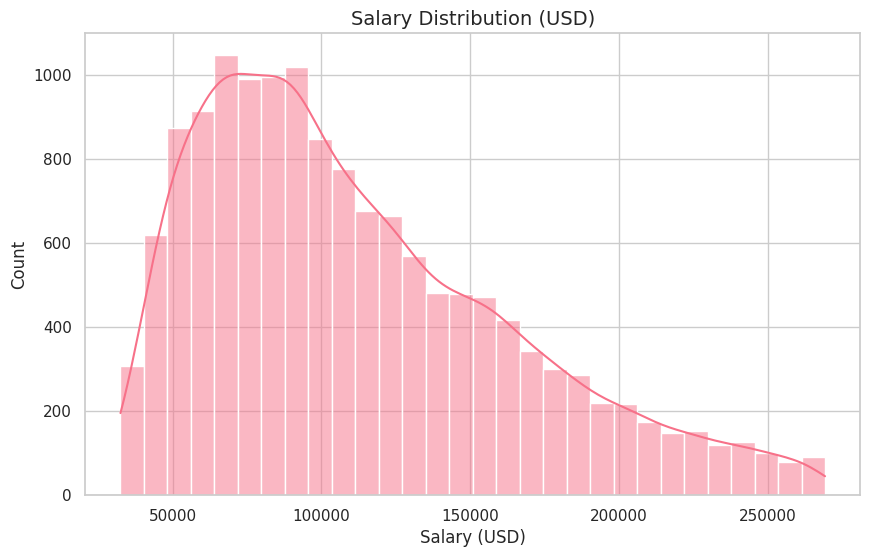

Insight: The salary distribution shows the range of AI job salaries, helping identify common pay brackets.


In [37]:
plt.figure(figsize=(10, 6))
sns.histplot(data['salary_usd'], kde=True, bins=30)
plt.title('Salary Distribution (USD)', fontsize=14)
plt.xlabel('Salary (USD)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()
print("Insight: The salary distribution shows the range of AI job salaries, helping identify common pay brackets.")

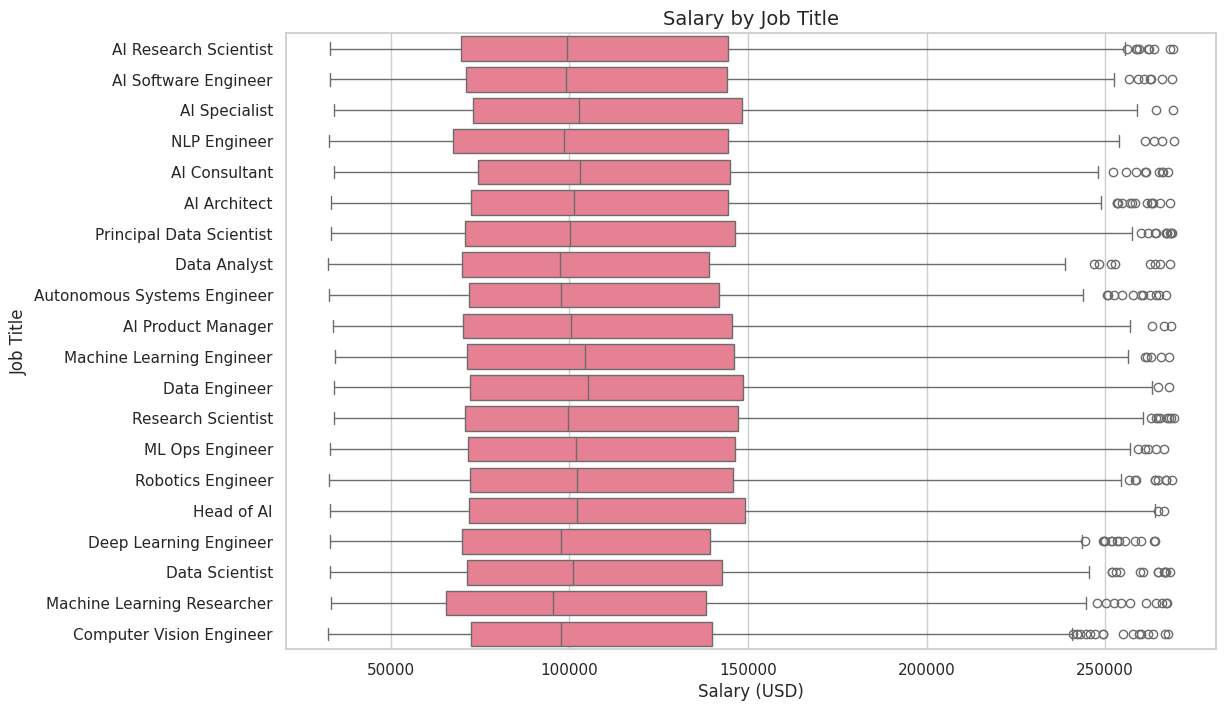

Insight: Roles like AI Specialist or Data Analyst may command higher salaries, reflecting specialized skills.


In [38]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='salary_usd', y='job_title', data=data)
plt.title('Salary by Job Title', fontsize=14)
plt.xlabel('Salary (USD)', fontsize=12)
plt.ylabel('Job Title', fontsize=12)
plt.show()
print("Insight: Roles like AI Specialist or Data Analyst may command higher salaries, reflecting specialized skills.")

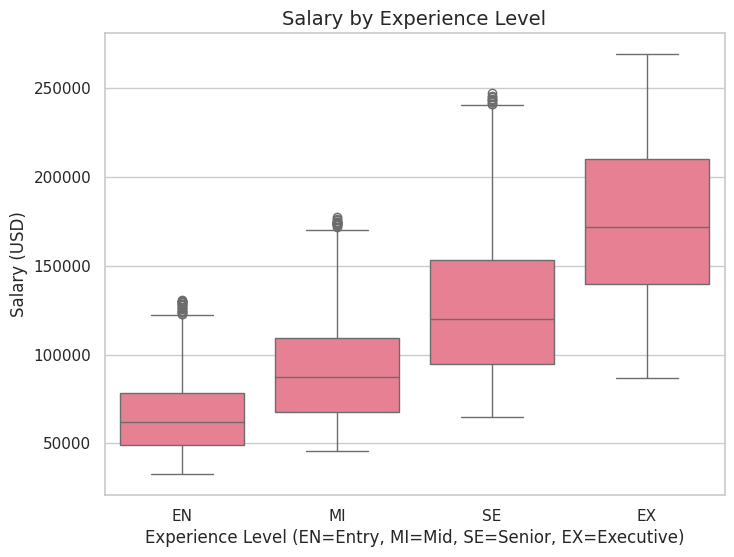

Insight: Senior and executive roles often earn more, showing the value of experience.


In [39]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='experience_level', y='salary_usd', data=data, order=['EN', 'MI', 'SE', 'EX'])
plt.title('Salary by Experience Level', fontsize=14)
plt.xlabel('Experience Level (EN=Entry, MI=Mid, SE=Senior, EX=Executive)', fontsize=12)
plt.ylabel('Salary (USD)', fontsize=12)
plt.show()
print("Insight: Senior and executive roles often earn more, showing the value of experience.")

Salary by Company Location (Top 10 locations)

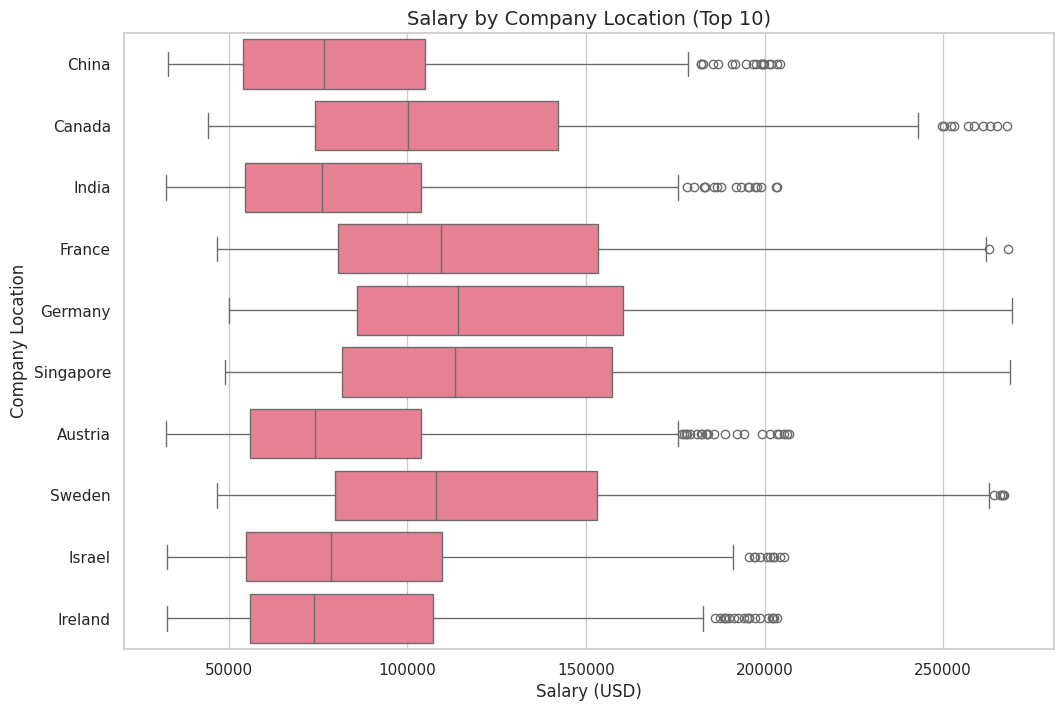

Insight: Salaries vary by region, with some countries offering higher pay due to market demand.


In [40]:

top_locations = data['company_location'].value_counts().index[:10]
plt.figure(figsize=(12, 8))
sns.boxplot(x='salary_usd', y='company_location', data=data[data['company_location'].isin(top_locations)])
plt.title('Salary by Company Location (Top 10)', fontsize=14)
plt.xlabel('Salary (USD)', fontsize=12)
plt.ylabel('Company Location', fontsize=12)
plt.show()
print("Insight: Salaries vary by region, with some countries offering higher pay due to market demand.")

Salary vs Years of Experience

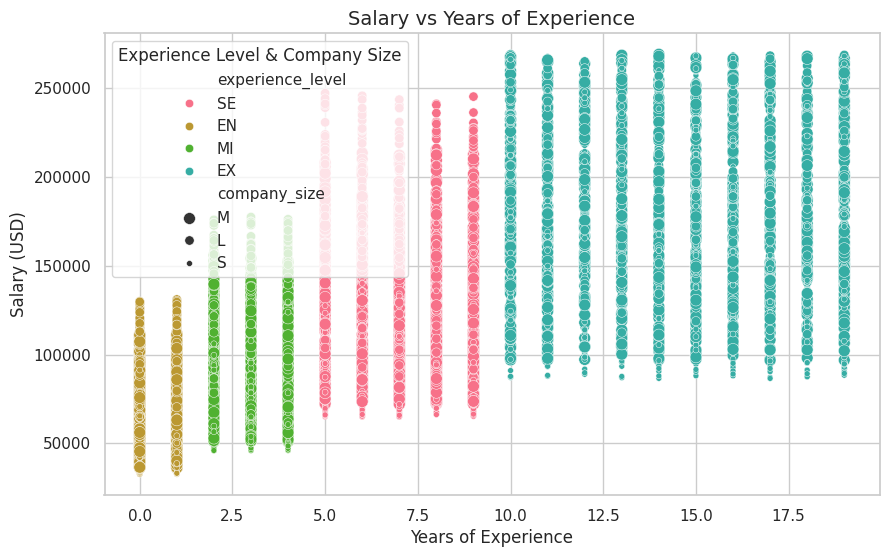

Insight: More experience generally correlates with higher pay, especially for senior roles.


In [41]:

plt.figure(figsize=(10, 6))
sns.scatterplot(x='years_experience', y='salary_usd', data=data, hue='experience_level', size='company_size')
plt.title('Salary vs Years of Experience', fontsize=14)
plt.xlabel('Years of Experience', fontsize=12)
plt.ylabel('Salary (USD)', fontsize=12)
plt.legend(title='Experience Level & Company Size')
plt.show()
print("Insight: More experience generally correlates with higher pay, especially for senior roles.")

 Remote Ratio vs Salary

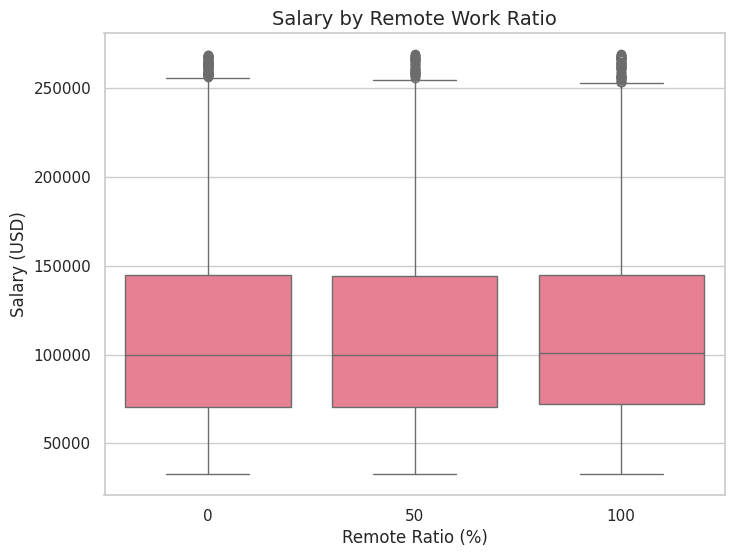

Insight: Remote jobs may have different salary structures, reflecting flexibility or cost savings.


In [42]:

plt.figure(figsize=(8, 6))
sns.boxplot(x='remote_ratio', y='salary_usd', data=data)
plt.title('Salary by Remote Work Ratio', fontsize=14)
plt.xlabel('Remote Ratio (%)', fontsize=12)
plt.ylabel('Salary (USD)', fontsize=12)
plt.show()
print("Insight: Remote jobs may have different salary structures, reflecting flexibility or cost savings.")

Correlation Heatmap

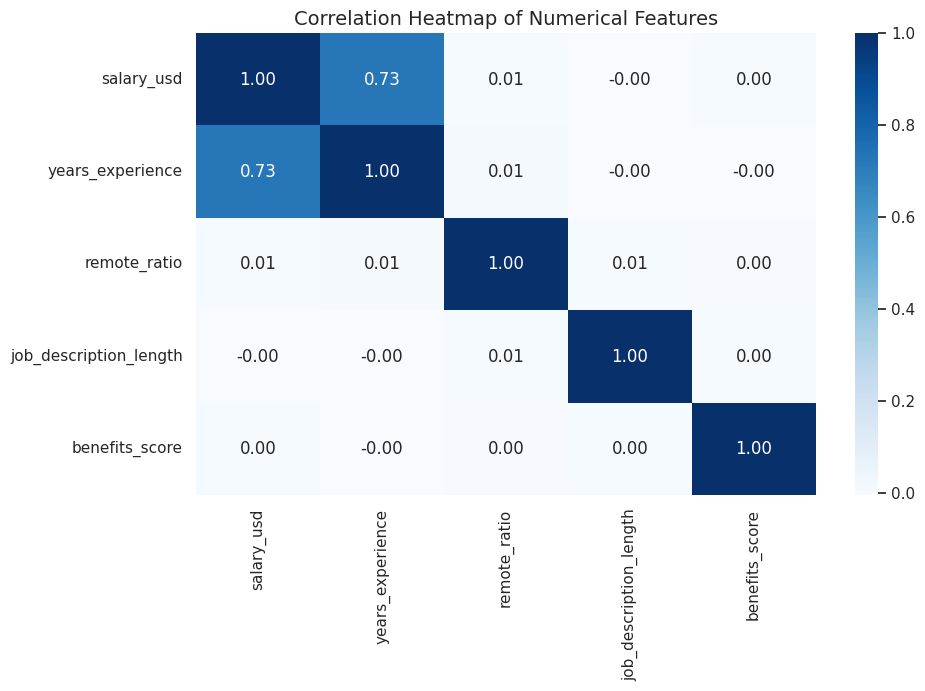

Insight: Years of experience and benefits score may strongly influence salary.


In [43]:

numerical_cols = ['salary_usd', 'years_experience', 'remote_ratio', 'job_description_length', 'benefits_score']
plt.figure(figsize=(10, 6))
sns.heatmap(data[numerical_cols].corr(), annot=True, cmap='Blues', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features', fontsize=14)
plt.show()
print("Insight: Years of experience and benefits score may strongly influence salary.")

- Encode Categorical Variables
- Label encoding for ordinal/low-cardinality features

In [44]:

le = LabelEncoder()
for col in ['experience_level', 'employment_type', 'company_size', 'education_required']:
    if col in data.columns:
        data[col] = le.fit_transform(data[col])

# One-hot encoding for high-cardinality features
data = pd.get_dummies(data, columns=['job_title', 'company_location', 'employee_residence', 'industry'], drop_first=True)

 Process required_skills (create binary columns for top 10 skills)

In [45]:

all_skills = set()
data['required_skills'].str.split(', ', expand=False).apply(lambda x: all_skills.update(x) if isinstance(x, list) else ())
top_skills = list(all_skills)[:10]  # Limit to top 10 skills
for skill in top_skills:
    data[f'skill_{skill}'] = data['required_skills'].apply(lambda x: 1 if isinstance(x, str) and skill in x else 0)
data = data.drop('required_skills', axis=1)
print("\nFeatures after encoding:", data.columns.tolist())


Features after encoding: ['salary_usd', 'experience_level', 'employment_type', 'company_size', 'remote_ratio', 'education_required', 'years_experience', 'job_description_length', 'benefits_score', 'job_title_AI Consultant', 'job_title_AI Product Manager', 'job_title_AI Research Scientist', 'job_title_AI Software Engineer', 'job_title_AI Specialist', 'job_title_Autonomous Systems Engineer', 'job_title_Computer Vision Engineer', 'job_title_Data Analyst', 'job_title_Data Engineer', 'job_title_Data Scientist', 'job_title_Deep Learning Engineer', 'job_title_Head of AI', 'job_title_ML Ops Engineer', 'job_title_Machine Learning Engineer', 'job_title_Machine Learning Researcher', 'job_title_NLP Engineer', 'job_title_Principal Data Scientist', 'job_title_Research Scientist', 'job_title_Robotics Engineer', 'company_location_Austria', 'company_location_Canada', 'company_location_China', 'company_location_Denmark', 'company_location_Finland', 'company_location_France', 'company_location_Germany',

Feature Scaling

In [46]:

scaler = StandardScaler()
numerical_cols = ['years_experience', 'remote_ratio', 'job_description_length', 'benefits_score']
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
print("\nSample scaled features:\n", data[numerical_cols].head())


Sample scaled features:
    years_experience  remote_ratio  job_description_length  benefits_score
0          0.560954      0.014947               -0.743875       -1.108940
1         -0.920546      1.238963               -0.410565       -1.591996
2         -0.735358     -1.209070                0.815043        1.306338
3          0.190579      0.014947               -0.276894        0.754274
4         -1.105733      1.238963                0.841083       -0.625885


Split Dataset

In [47]:

X = data.drop('salary_usd', axis=1)
y = data['salary_usd']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("\nTraining set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (11596, 89) (11596,)
Testing set shape: (2899, 89) (2899,)


In [48]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42)
}

results = {}
feature_importances = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    results[name] = {'R2': r2, 'MAE': mae, 'MSE': mse, 'RMSE': rmse}

    if name != 'Linear Regression':
        feature_importances[name] = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

Model Performance Comparison

<Figure size 1000x600 with 0 Axes>

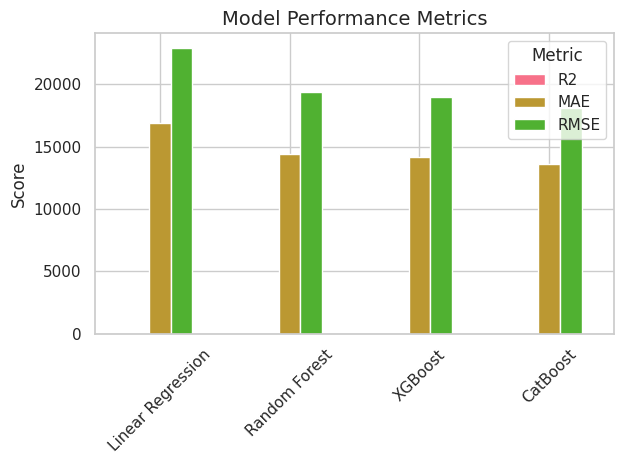


Model Performance Comparison:
                          R2           MAE           MSE          RMSE
Linear Regression  0.809566  16918.773456  5.262627e+08  22940.415882
Random Forest      0.864373  14389.089072  3.748038e+08  19359.851419
XGBoost            0.869599  14171.423868  3.603613e+08  18983.183680
CatBoost           0.881933  13586.192713  3.262772e+08  18063.144829


In [49]:

results_df = pd.DataFrame(results).T
plt.figure(figsize=(10, 6))
results_df[['R2', 'MAE', 'RMSE']].plot(kind='bar')
plt.title('Model Performance Metrics', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()
print("\nModel Performance Comparison:\n", results_df)

Feature Importance for Tree-Based Models

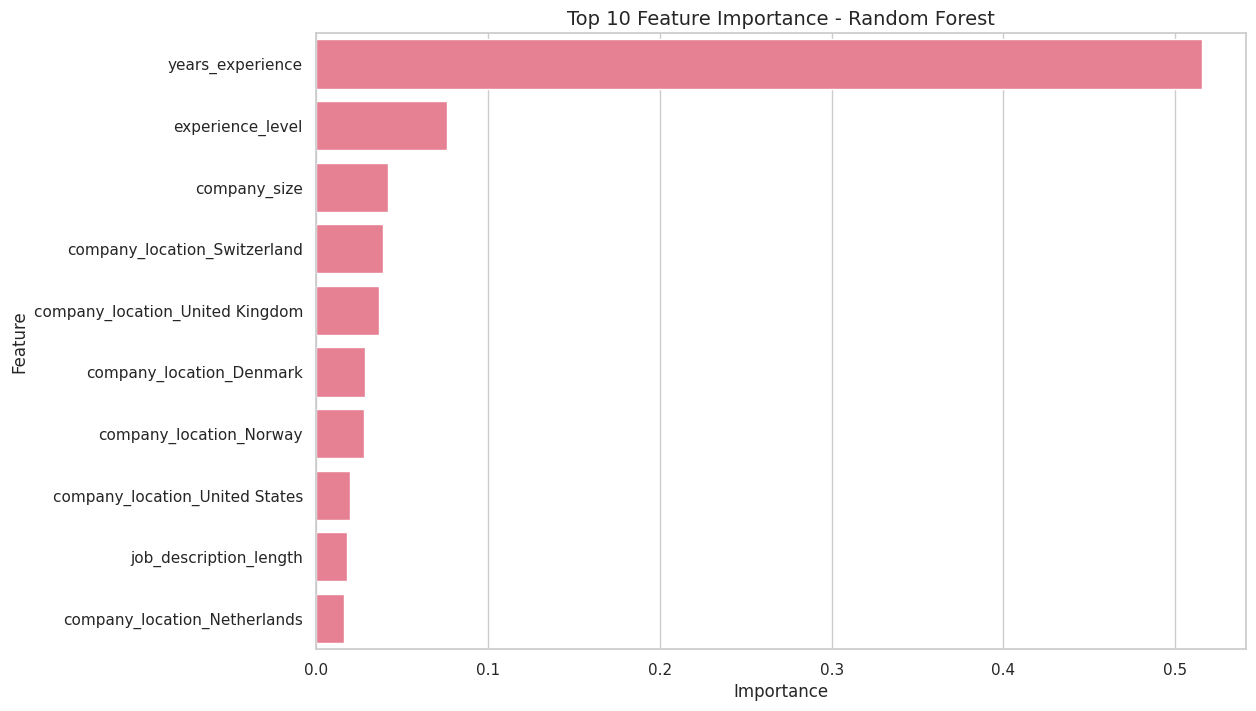


Insight from Random Forest: Features like years_experience, job titles, or specific skills drive salary predictions.


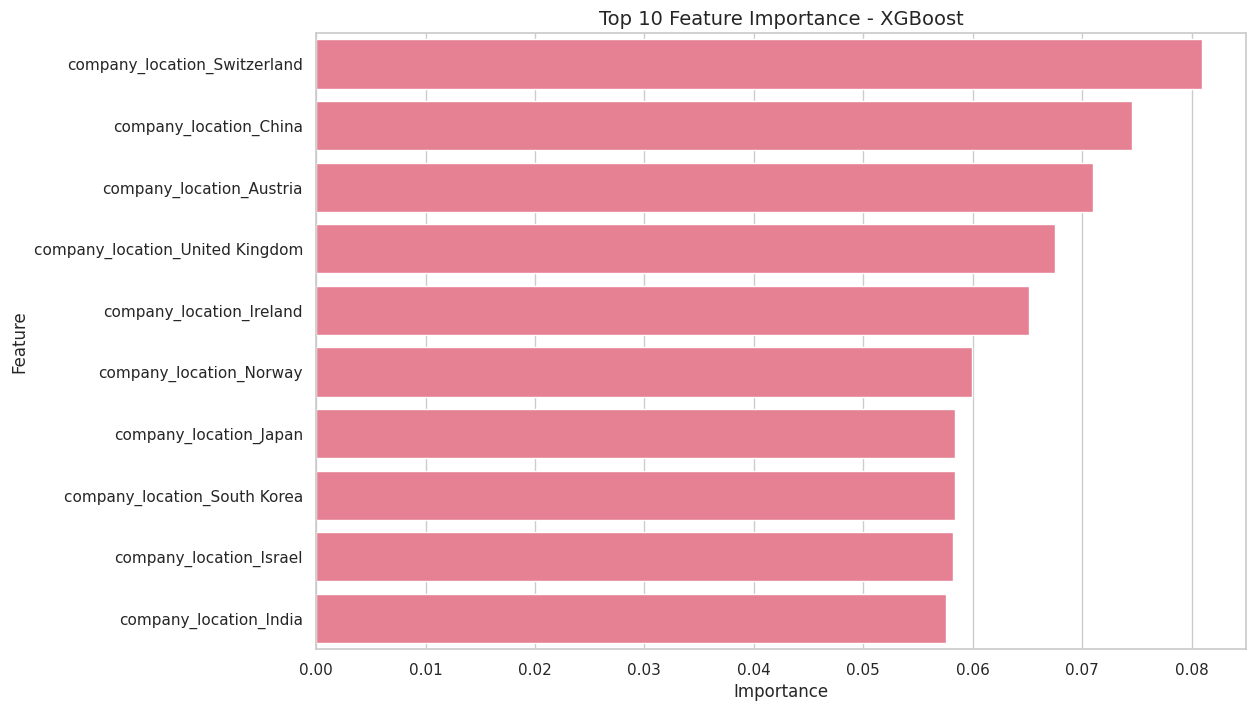


Insight from XGBoost: Features like years_experience, job titles, or specific skills drive salary predictions.


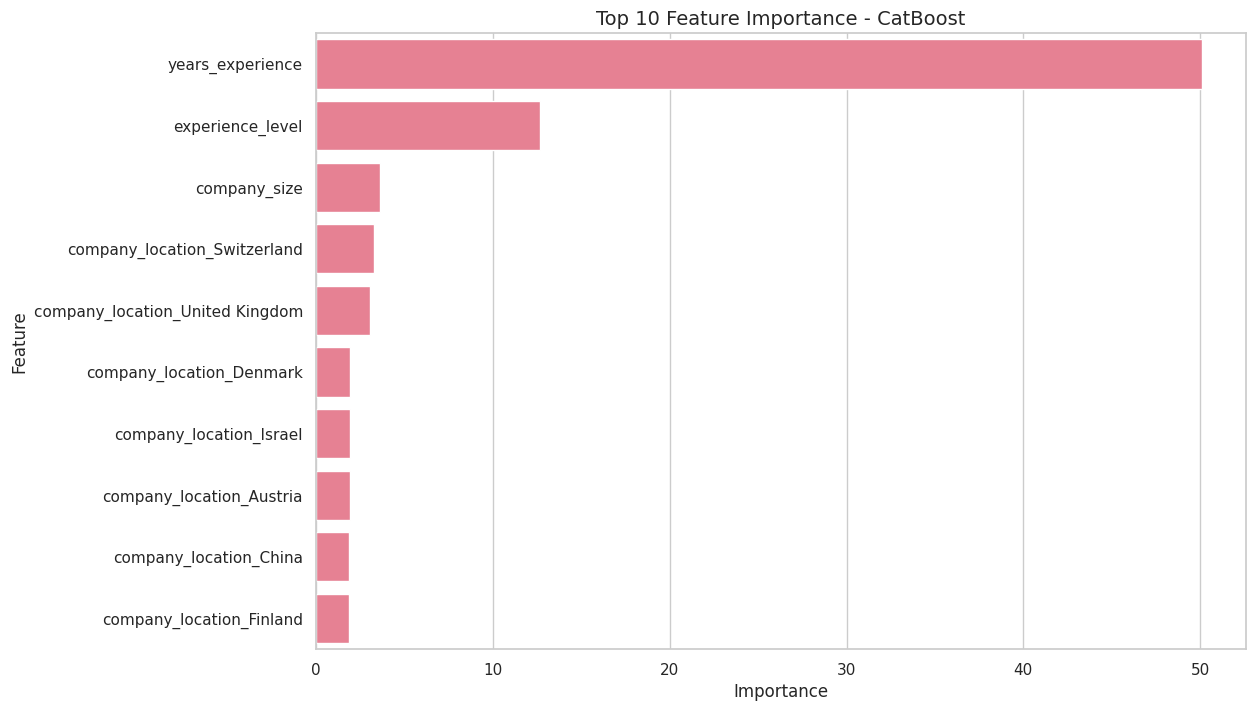


Insight from CatBoost: Features like years_experience, job titles, or specific skills drive salary predictions.


In [50]:

for name, fi in feature_importances.items():
    plt.figure(figsize=(12, 8))
    sns.barplot(x=fi.values[:10], y=fi.index[:10])
    plt.title(f'Top 10 Feature Importance - {name}', fontsize=14)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.show()
    print(f"\nInsight from {name}: Features like years_experience, job titles, or specific skills drive salary predictions.")

Actual vs Predicted Salaries

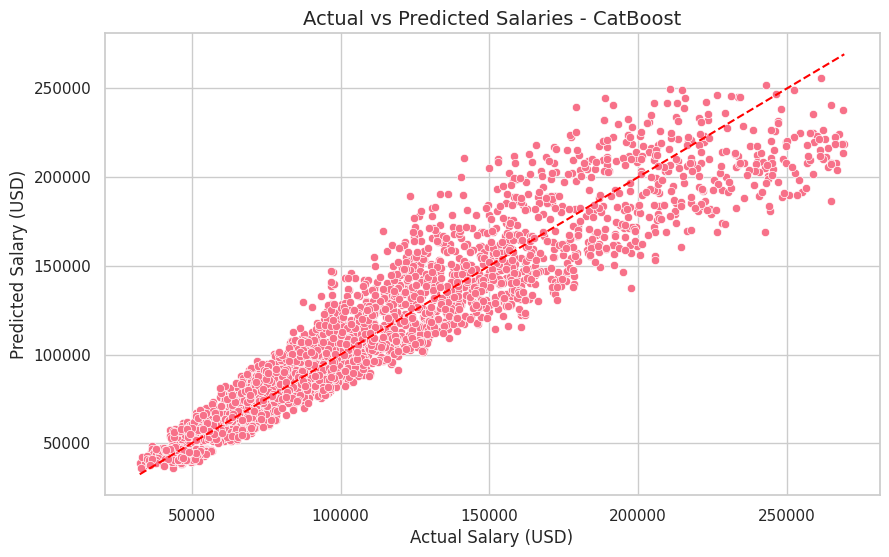

Insight: Points near the red dashed line show accurate predictions, indicating model reliability.


In [51]:

best_model_name = results_df['R2'].idxmax()
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_best)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(f'Actual vs Predicted Salaries - {best_model_name}', fontsize=14)
plt.xlabel('Actual Salary (USD)', fontsize=12)
plt.ylabel('Predicted Salary (USD)', fontsize=12)
plt.show()
print("Insight: Points near the red dashed line show accurate predictions, indicating model reliability.")


Best Model Prediction

In [52]:

print(f"\nBest Model: {best_model_name} with R2 Score: {results_df.loc[best_model_name, 'R2']:.2f}")

sample = X_test.iloc[[0]]
prediction = best_model.predict(sample)
print(f"Sample Prediction: ${prediction[0]:,.2f} USD for a sample role.")

import joblib
joblib.dump(best_model, f'best_model_{best_model_name.lower().replace(" ", "_")}.pkl')
print(f"Best model saved as 'best_model_{best_model_name.lower().replace(' ', '_')}.pkl'")


Best Model: CatBoost with R2 Score: 0.88
Sample Prediction: $55,282.06 USD for a sample role.
Best model saved as 'best_model_catboost.pkl'
